<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-wiki-cs-dataset" data-toc-modified-id="Example-wiki-cs-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example wiki cs dataset</a></span></li><li><span><a href="#Dataset-information" data-toc-modified-id="Dataset-information-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset information</a></span></li><li><span><a href="#Dataset-metadata" data-toc-modified-id="Dataset-metadata-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset metadata</a></span></li><li><span><a href="#Defining-a-GCN" data-toc-modified-id="Defining-a-GCN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Defining a GCN</a></span></li><li><span><a href="#Training-a-GCN" data-toc-modified-id="Training-a-GCN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training a GCN</a></span></li><li><span><a href="#Storing-model-to-disk" data-toc-modified-id="Storing-model-to-disk-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Storing model to disk</a></span></li><li><span><a href="#Load-model-from-disk" data-toc-modified-id="Load-model-from-disk-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Load model from disk</a></span></li><li><span><a href="#Visualized-learned-embeddings" data-toc-modified-id="Visualized-learned-embeddings-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualized learned embeddings</a></span></li></ul></div>

This notebook shows 

- How to loads the `wiki-cs-dataset`.
- How to define a Graph Neural Network for a node classification task
- How to train the GNN and store it to disk


### Example wiki cs dataset



The dataset can be downloaded from 

- https://github.com/pmernyei/wiki-cs-dataset

In [8]:
import json
from itertools import chain

import torch
from torch_geometric.data import InMemoryDataset, Data, download_url

import pandas as pd
import json

In [9]:
ls

README.md                   model.py
app.py                      requirements.txt
dataset_loader.py           train_and_save_model.ipynb
model/                      wiki-cs-dataset/


### Dataset information

In [10]:
from torch_geometric.datasets import wikics

In [11]:
dataset = wikics.WikiCS('./wiki-cs-dataset_autodownload')

Processing...
Done!


In [19]:
dataset.data

Data(edge_index=[2, 297110], stopping_mask=[11701, 20], test_mask=[11701], train_mask=[11701, 20], val_mask=[11701, 20], x=[11701, 300], y=[11701])

In [20]:
dataset.num_classes

10

In [21]:
# the 300 dimension corresponds to glove embebeddings
# for each word in the document averaged over
dataset.data.x.shape

torch.Size([11701, 300])

In [22]:
dataset.data.y.shape

torch.Size([11701])

In [23]:
dataset.data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
dataset.data.edge_index.shape

torch.Size([2, 297110])

In [25]:
dataset.processed_dir

'wiki-cs-dataset_autodownload/processed'

### Dataset metadata

In the metadata.json file from wikipedia

`https://en.wikipedia.org/wiki/Program_compatibility_date_range`

- parse the titles form the dataset to get 11701 titles
- construct a url for each document in the dataset with 
    - `f'https://en.wikipedia.org/wiki/{title}'`



In [26]:
dataset.data.x.shape

torch.Size([11701, 300])

In [46]:
metadata = json.load(open('wiki-cs-dataset/dataset/metadata.json'))
metadata.keys()

dict_keys(['labels', 'nodes'])

In [47]:
metadata['labels']

{'0': 'Computational linguistics',
 '1': 'Databases',
 '2': 'Operating systems',
 '3': 'Computer architecture',
 '4': 'Computer security',
 '5': 'Internet protocols',
 '6': 'Computer file systems',
 '7': 'Distributed computing architecture',
 '8': 'Web technology',
 '9': 'Programming language topics'}

In [48]:
len(metadata['nodes'])

11701

For each node we have the following information

In [49]:
metadata['nodes'][40].keys()

dict_keys(['id', 'title', 'label', 'outlinks', 'tokens'])

Note that from a node `title` we can construct a valid URL from wikipedia as follows:

In [50]:
def create_url(title):
    return f'https://en.wikipedia.org/wiki/{title}'

In [51]:
pos = 1900
create_url(metadata['nodes'][pos]['title'])

'https://en.wikipedia.org/wiki/Alexandre_Julliard'

### Defining a GCN

In [20]:
import model
from model import GCN

In [21]:
num_classes = len(dataset.data.y.unique())
num_features = dataset.data.x.shape[1]

model = GCN(num_node_features=num_features, 
    num_classes=num_classes, 
    hidden_channels=128)

In [101]:
model

GCN(
  (conv1): GCNConv(300, 128)
  (conv2): GCNConv(128, 10)
)

### Training a GCN

In [102]:
data = dataset.data 
loss_values = []

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(model, data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      #mask = data.train_mask[:,0]
      #loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.  
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model, data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

n_epochs = 400

for epoch in range(1, n_epochs):
    loss = train(model, data)
    loss_values.append(loss)
    print(f'\rEpoch: {epoch:03d}, Loss: {loss:.4f}', end='')

Epoch: 200, Loss: 0.5955

In [104]:
test_acc = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8353


### Storing model to disk

In [110]:
num_features

300

In [105]:
torch.save(model.state_dict(), './model/saved_model.torch')

### Load model from disk

In [111]:
model2 = GCN(num_node_features= num_features, 
             num_classes= num_classes,
             hidden_channels=128)

model2.load_state_dict(torch.load('./model/saved_model.torch'))

<All keys matched successfully>

In [119]:
test(model2, data)

0.8353001539250898

### Visualized learned embeddings

In [121]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

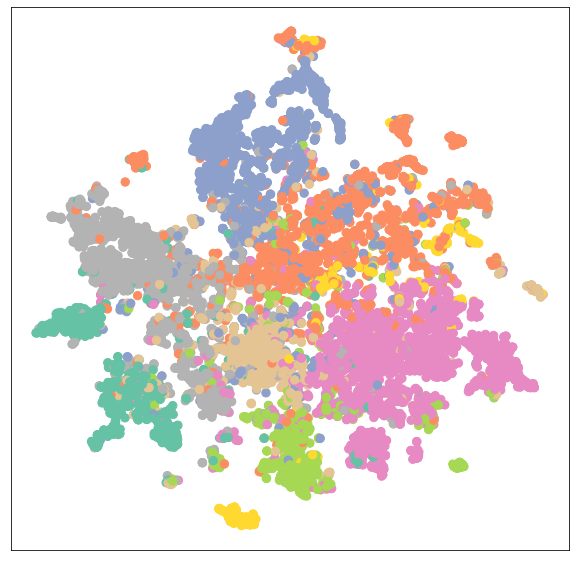

In [122]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)